<a href="https://colab.research.google.com/github/annodomini80/rnn-python/blob/master/solar_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

In [54]:
def get_feature(data,
                seasonality = False,
                period = 12):
  """

  Get features and target from the data attributes for Time series forecasting.
  A seasonal decomposition is performed if seasonality is True.
  Seasonality is a characteristic of a time series in which the data experiences
  regular and predictable changes over time.

  Args:
    data: DataFrame
    seasonality: Boolean Flag to get seasonality
    period: Period of seasonality
  Returns:

    features: features
    target: target
    result: result of seasonal decomposition

  """

  print("period, seasonality: ", period, seasonality)

  features = data[['temperature',
                   'radiation_direct_horizontal',
                   'radiation_diffuse_horizontal']]

# Seasonal Decomposing into Trend, Seasonality and Residual Noise

  if seasonality:
    result = seasonal_decompose(data['solar_generation_actual'],
                                model='additive',
                                period=period)

    result.plot()
    plt.show()

    # Add components to the original DataFrame
    data['trend'] = result.trend
    data['seasonal'] = result.seasonal

    # Drop NaN values
    data.dropna(inplace=True)

    # Sort the data by datetime index
    data.sort_index(inplace=True)

    # Preprocess the data
    features = data[['temperature',
                     'radiation_direct_horizontal',
                     'radiation_diffuse_horizontal',
                     'trend',
                     'seasonal']]

  target = data['solar_generation_actual']

  return features, target, result

In [55]:
def data_loader(scaled_features,
                scaled_target,
                time_step = 48):
  """

  Load the data and split it into training and testing sets.

  Args:
    scaled_features: scaled features
    scaled_target: scaled target
    time_step: context window

  Returns:
    X_train: training data
    X_test: testing data
    y_train: training target
    y_test: testing target

  """

  print("timestep: ", time_step)

  # Create sequences for LSTM
  def create_dataset(features, target, time_step=1):
      """
      Create sequences for LSTM.
      """

      X, y = [], []
      for i in range(len(features) - time_step):
          X.append(features[i:(i + time_step), :])
          y.append(target[i + time_step, 0])
      return np.array(X), np.array(y)


  X, y = create_dataset(scaled_features,
                        scaled_target,
                        time_step=time_step)

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      test_size=0.2,
                                                      random_state = 42,
                                                      shuffle = False)

  return X_train, X_test, y_train, y_test

In [56]:
def prediction_network(X_train,
                       y_train,
                       epoch = 50,
                       batch_size = 16,
                       learning_rate = 0.001):
  """

  Build the LSTM model for time series prediction and train it.


  Args:
    X_train: Training data
    y_train: values
    epoch: number of iteration
    batch_size: batch size
    learning_rate: learning rate for Adam optimizer

  Returns:
    model: trained model

  """

  print("epoch, batch_size, learning_rate: ", epoch, batch_size, learning_rate)
  # Build the LSTM model

  model = Sequential()
  model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Use Input layer
  model.add(LSTM(50, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(50, return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(1))  # Output layer

  # Optimizer and Loss function
  model.compile(optimizer=Adam(learning_rate=learning_rate),
                loss='mean_squared_error')

  # Define early stopping to avoid overfitting
  early_stop = EarlyStopping(monitor='val_loss',
                             patience=10)

  # Train the model
  model.fit(X_train,
            y_train,
            epochs=epoch,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=[early_stop],
            shuffle=False)

  return model

In [57]:
# Load your dataset

solar_data = pd.read_excel('/content/Time_Series_FR_15-19.xlsx')
weather_data = pd.read_excel('/content/weather_data_FR_15-19.xlsx')

In [58]:
solar_data['utc_timestamp'] = pd.to_datetime(solar_data['utc_timestamp'])
solar_data.set_index('utc_timestamp', inplace=True)
weather_data['utc_timestamp'] = pd.to_datetime(weather_data['utc_timestamp'])
weather_data.set_index('utc_timestamp', inplace=True)

# Merge solar and weather datasets on 'date'
merged_data = pd.merge(solar_data, weather_data, on='utc_timestamp')

# Drop NaN values
merged_data.dropna(inplace=True)

# Sort the data by datetime index
merged_data.sort_index(inplace=True)

## investigate the data
print(merged_data.head())

                     solar_generation_actual  temperature  \
utc_timestamp                                               
2015-01-01 08:00:00                    385.0        0.861   
2015-01-01 09:00:00                   1053.0        2.313   
2015-01-01 10:00:00                   1635.0        3.606   
2015-01-01 11:00:00                   1883.0        4.323   
2015-01-01 12:00:00                   1857.0        4.336   

                     radiation_direct_horizontal  radiation_diffuse_horizontal  
utc_timestamp                                                                   
2015-01-01 08:00:00                   115.398024                     73.512876  
2015-01-01 09:00:00                   182.529792                     85.103308  
2015-01-01 10:00:00                   203.812548                     95.075152  
2015-01-01 11:00:00                   178.493059                    102.770341  
2015-01-01 12:00:00                   114.941429                    103.067771  


period, seasonality:  24 True


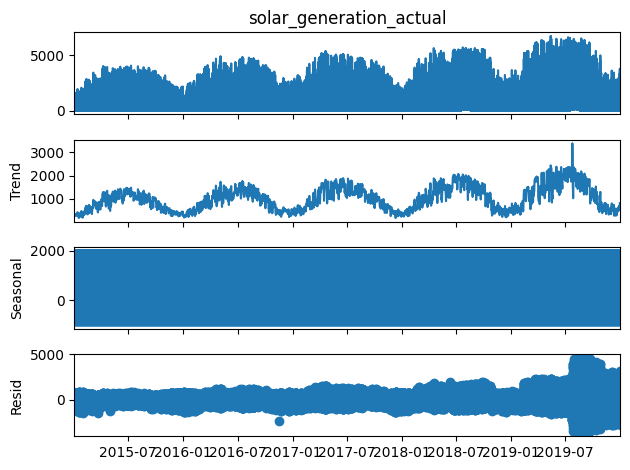

In [97]:
features, target, result = get_feature(merged_data,
                                       seasonality=True,
                                       period= 24)

# Scale the data
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

scaled_features = scaler_features.fit_transform(features)
scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

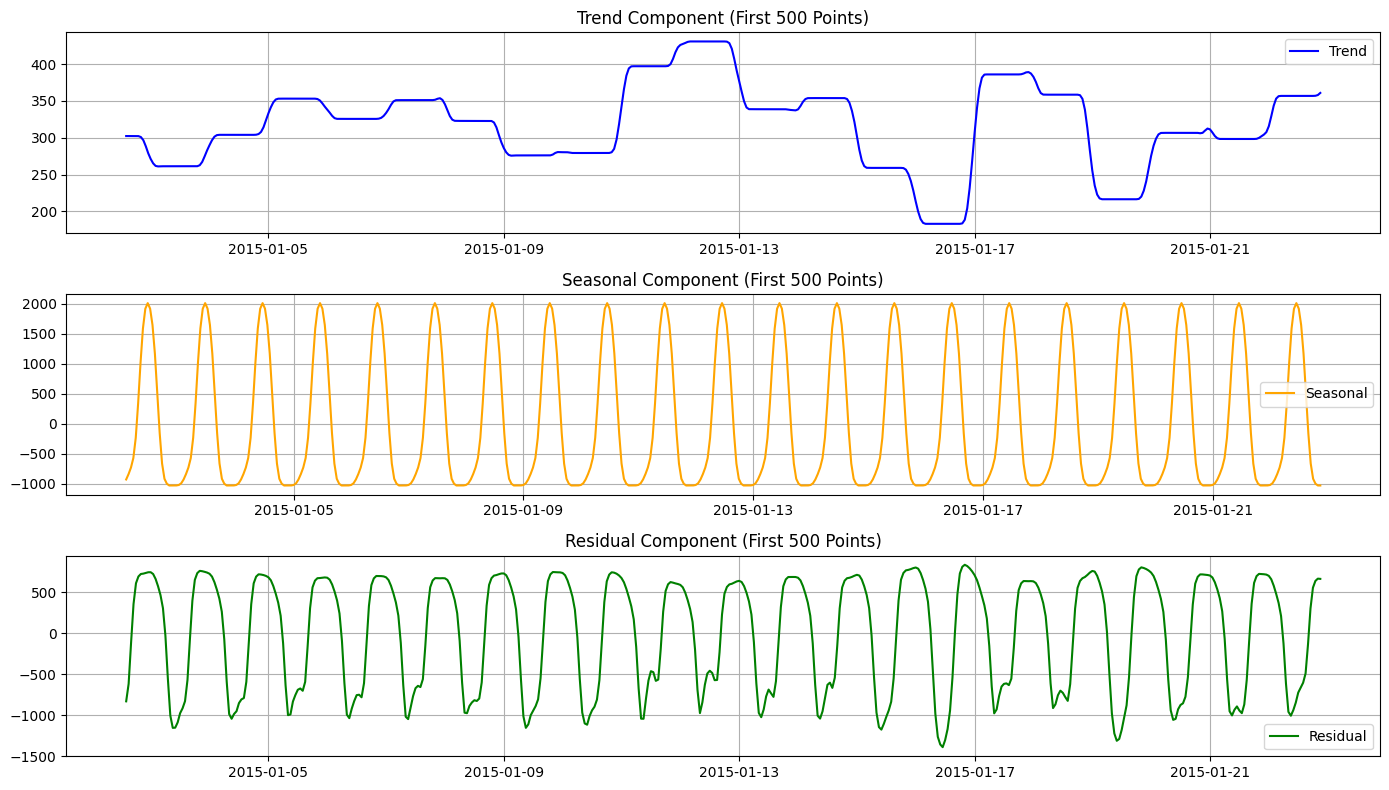

In [98]:
# Plot Trend, Seasonality and Residual Noise for first 500 points
# Set up the figure
plt.figure(figsize=(14, 8))

# Plot Trend
plt.subplot(3, 1, 1)
plt.plot(result.trend[:500], label='Trend', color='blue')
plt.title('Trend Component (First 500 Points)')
plt.legend()
plt.grid()

# Plot Seasonal
plt.subplot(3, 1, 2)
plt.plot(result.seasonal[:500], label='Seasonal', color='orange')
plt.title('Seasonal Component (First 500 Points)')
plt.legend()
plt.grid()

# Plot Residual
plt.subplot(3, 1, 3)
plt.plot(result.resid[:500], label='Residual', color='green')
plt.title('Residual Component (First 500 Points)')
plt.legend()
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()

In [99]:
X_train, X_test, y_train, y_test = data_loader(scaled_features,
                                               scaled_target,
                                               time_step=48)

timestep:  48


In [ ]:
model = prediction_network(X_train,
                           y_train,
                           epoch=100,
                           batch_size=16,
                           learning_rate=0.001)

epoch, batch_size, learning_rate:  100 16 0.001
Epoch 1/100
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 2/100
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 7.7601e-04 - val_loss: 0.0027
Epoch 3/100
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 5.8804e-04 - val_loss: 0.0032
Epoch 4/100


In [76]:
# Predicting the test set results
predicted_values = model.predict(X_test)

# Inverse transform the predictions to original scale
predictions_inverse = scaler_target.inverse_transform(predicted_values)
y_test_inverse = scaler_target.inverse_transform(y_test.reshape(-1, 1))


274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Mean Squared Error on Test Set: 50217.985342540676


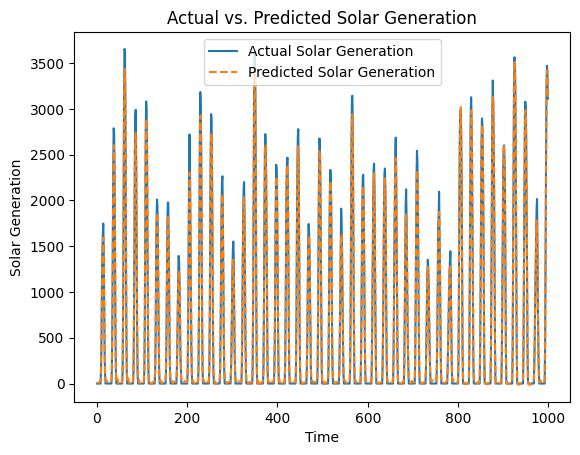

In [77]:
# Calculate Mean Squared Error on the test set
mse = mean_squared_error(y_test_inverse, predictions_inverse)
print(f'Mean Squared Error on Test Set: {mse}')

# Create the Plot for first 1000 points
plt.plot (y_test_inverse[:1000], label='Actual Solar Generation')
plt.plot(predictions_inverse[:1000], label='Predicted Solar Generation', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Solar Generation')
plt.title('Actual vs. Predicted Solar Generation')
plt.legend()
plt.show()